In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

2025-12-11 17:16:34.984856: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 17:16:35.309184: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 17:16:36.434202: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
d = np.load("../data/training_data/splits.npz", allow_pickle=True)
X_train = d["X_train"]
X_test = d["X_test"]
y_train = d["y_train"]
y_test = d["y_test"]

In [3]:
d = np.load("../data/training_data/features_labels.npz", allow_pickle=True)
X = d["X"]
y = d["y"]

In [4]:
def create_basic_ann(input_dim, num_classes, hidden_layers=[64, 32]):
    """
    Create a basic ANN model
    """
    model = models.Sequential()
    
    # Input layer
    model.add(layers.Dense(hidden_layers[0], activation='relu', input_shape=(input_dim,)))
    model.add(layers.Dropout(0.2))  # Dropout for regularization
    
    # Hidden layers
    for units in hidden_layers[1:]:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(0.2))
    
    # Output layer
    if num_classes == 2:
        model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
        loss = 'binary_crossentropy'
        metrics = ['accuracy']
    else:
        model.add(layers.Dense(num_classes, activation='softmax'))  # Multi-class
        loss = 'sparse_categorical_crossentropy'
        metrics = ['accuracy']
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=metrics
    )
    
    return model

# Get dataset info
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

print(f"Input dimensions: {input_dim}")
print(f"Number of classes: {num_classes}")

# Create basic model
basic_ann = create_basic_ann(input_dim, num_classes)
basic_ann.summary()

Input dimensions: 16
Number of classes: 4


W0000 00:00:1765453600.224117   15794 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,300 (12.89 KB)

 Trainable params: 3,300 (12.89 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Ensure data is properly formatted for neural network
X_train_nn = X_train.astype('float32')
X_test_nn = X_test.astype('float32')

# For binary classification, ensure y is float for sigmoid
if num_classes == 2:
    y_train_nn = y_train.astype('float32')
    y_test_nn = y_test.astype('float32')
else:
    y_train_nn = y_train
    y_test_nn = y_test

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.0001,
    verbose=1
)

print("Training Basic ANN Model...")
start_time = time.time()

# Train the model
history = basic_ann.fit(
    X_train_nn, y_train_nn,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

Training Basic ANN Model...
Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5018 - loss: 1.0835 - val_accuracy: 0.6820 - val_loss: 0.8781 - learning_rate: 0.0010
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.6627 - loss: 0.7978 - val_accuracy: 0.7453 - val_loss: 0.6744 - learning_rate: 0.0010
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.7213 - loss: 0.6591 - val_accuracy: 0.7984 - val_loss: 0.5602 - learning_rate: 0.0010
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.7500 - loss: 0.5865 - val_accuracy: 0.8109 - val_loss: 0.4936 - learning_rate: 0.0010
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.7791 - loss: 0.5224 - val_accuracy: 0.8281 - val_loss: 0.4488 - learning_rate: 0.0010
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.8006 - loss: 0.4774 - val_accuracy: 0.8289 - val_loss: 0.4164 - learning_rate: 0.0010
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [6]:
# Evaluate the model
train_loss, train_accuracy = basic_ann.evaluate(X_train_nn, y_train_nn, verbose=0)
test_loss, test_accuracy = basic_ann.evaluate(X_test_nn, y_test_nn, verbose=0)

print("Basic ANN Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training time: {training_time:.2f} seconds")

# Make predictions
if num_classes == 2:
    y_pred_proba = basic_ann.predict(X_test_nn)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
else:
    y_pred_proba = basic_ann.predict(X_test_nn)
    y_pred = np.argmax(y_pred_proba, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Basic ANN Results:
Training Accuracy: 0.9695
Test Accuracy: 0.9394
Training time: 12.47 seconds
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       425
           1       0.97      0.94      0.95       379
           2       0.88      0.93      0.91       397
           3       0.91      0.88      0.90       399

    accuracy                           0.94      1600
   macro avg       0.94      0.94      0.94      1600
weighted avg       0.94      0.94      0.94      1600



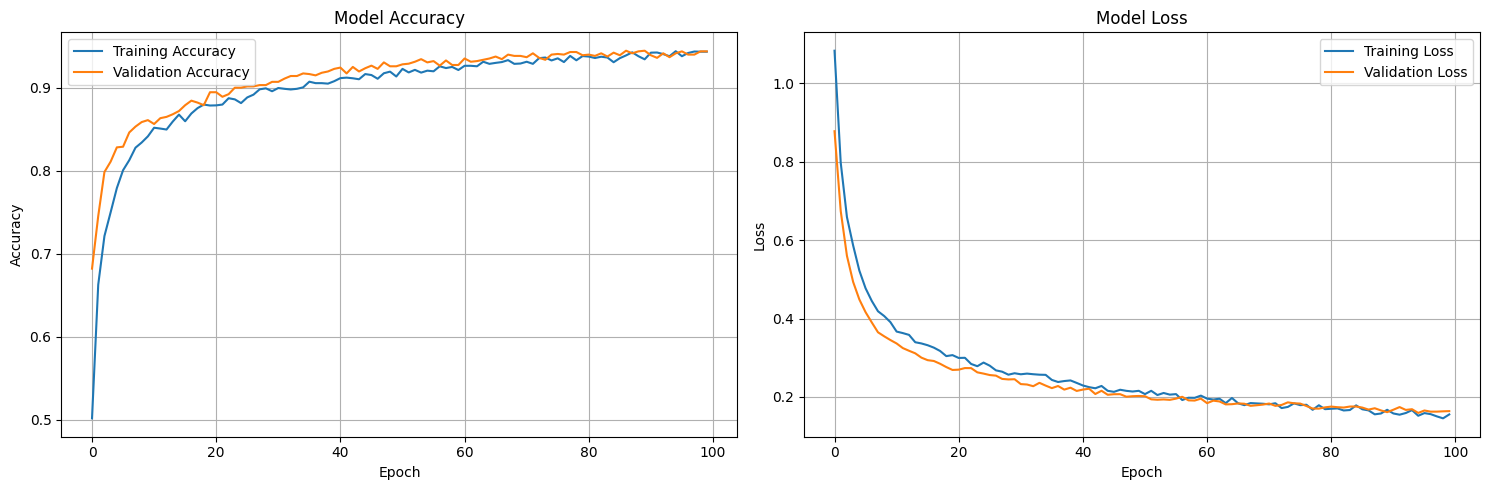

In [7]:
def plot_training_history(history):
    """
    Plot training history for accuracy and loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [8]:
def create_advanced_ann(input_dim, num_classes, architecture='medium'):
    """
    Create different ANN architectures
    """
    model = models.Sequential()
    
    if architecture == 'simple':
        # Simple architecture
        model.add(layers.Dense(64, activation='relu', input_shape=(input_dim,)))
        model.add(layers.Dropout(0.3))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.3))
        
    elif architecture == 'medium':
        # Medium architecture
        model.add(layers.Dense(128, activation='relu', input_shape=(input_dim,)))
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.2))
        
    elif architecture == 'complex':
        # Complex architecture
        model.add(layers.Dense(256, activation='relu', input_shape=(input_dim,)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.3))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.3))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.2))
    
    # Output layer
    if num_classes == 2:
        model.add(layers.Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        model.add(layers.Dense(num_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'
    
    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

# Test different architectures
architectures = ['simple', 'medium', 'complex']
results = {}

for arch in architectures:
    print(f"\n{'='*50}")
    print(f"Testing {arch.upper()} Architecture")
    print(f"{'='*50}")
    
    model = create_advanced_ann(input_dim, num_classes, architecture=arch)
    
    # Train with fewer epochs for testing
    history = model.fit(
        X_train_nn, y_train_nn,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
    
    # Evaluate
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test_nn, verbose=0)
    results[arch] = {
        'model': model,
        'history': history,
        'accuracy': test_accuracy
    }
    
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Compare architectures
print("\nArchitecture Comparison:")
for arch, result in results.items():
    print(f"{arch:8}: {result['accuracy']:.4f}")


Testing SIMPLE Architecture
Test Accuracy: 0.9162

Testing MEDIUM Architecture
Test Accuracy: 0.9606

Testing COMPLEX Architecture
Test Accuracy: 0.9450

Architecture Comparison:
simple  : 0.9162
medium  : 0.9606
complex : 0.9450


In [9]:
try:
    import keras_tuner as kt
    
    def build_model(hp):
        model = models.Sequential()
        
        # Tune number of hidden layers
        for i in range(hp.Int('num_layers', 1, 4)):
            # Tune number of units
            model.add(layers.Dense(
                units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                activation='relu'
            ))
            # Tune dropout rate
            model.add(layers.Dropout(
                hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)
            ))
        
        # Output layer
        if num_classes == 2:
            model.add(layers.Dense(1, activation='sigmoid'))
            loss = 'binary_crossentropy'
        else:
            model.add(layers.Dense(num_classes, activation='softmax'))
            loss = 'sparse_categorical_crossentropy'
        
        # Tune learning rate
        learning_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=loss,
            metrics=['accuracy']
        )
        
        return model
    
    # Initialize tuner
    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='ann_tuning',
        project_name='ann_hyperparameter_tuning'
    )
    
    print("Starting Hyperparameter Tuning...")
    tuner.search(
        X_train_nn, y_train_nn,
        epochs=30,
        validation_split=0.2,
        batch_size=32,
        verbose=1
    )
    
    # Get best model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    tuned_ann = tuner.hypermodel.build(best_hps)
    
    print("\nBest Hyperparameters:")
    print(f"Number of layers: {best_hps.get('num_layers')}")
    for i in range(best_hps.get('num_layers')):
        print(f"Layer {i+1} units: {best_hps.get(f'units_{i}')}")
        print(f"Layer {i+1} dropout: {best_hps.get(f'dropout_{i}')}")
    print(f"Learning rate: {best_hps.get('lr')}")
    
    # Train best model
    history_tuned = tuned_ann.fit(
        X_train_nn, y_train_nn,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Evaluate tuned model
    tuned_loss, tuned_accuracy = tuned_ann.evaluate(X_test_nn, y_test_nn, verbose=0)
    print(f"Tuned ANN Test Accuracy: {tuned_accuracy:.4f}")
    
except ImportError:
    print("Keras Tuner not available. Skipping hyperparameter tuning.")

Reloading Tuner from ann_tuning/ann_hyperparameter_tuning/tuner0.json
Starting Hyperparameter Tuning...

Best Hyperparameters:
Number of layers: 2
Layer 1 units: 256
Layer 1 dropout: 0.5
Layer 2 units: 128
Layer 2 dropout: 0.1
Learning rate: 0.003321315942397082
Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6973 - loss: 0.6701 - val_accuracy: 0.8289 - val_loss: 0.4105 - learning_rate: 0.0033
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.8203 - loss: 0.4143 - val_accuracy: 0.8641 - val_loss: 0.3459 - learning_rate: 0.0033
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.8479 - loss: 0.3732 - val_accuracy: 0.8742 - val_loss: 0.3159 - learning_rate: 0.0033
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.8641 - loss: 0.3301 - val_accuracy: 0.8852 - val_loss: 0.2968 - learning_rate: 0.0033
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.8770 - loss: 0.3094 - val_accuracy: 0.8836 - val_l

In [10]:
def ann_cross_validation(X, y, n_splits=5, epochs=50):
    """
    Perform cross-validation for ANN
    """
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []
    fold_no = 1
    
    for train_idx, val_idx in kfold.split(X, y):
        print(f'\nTraining fold {fold_no}...')
        
        # Create model for this fold
        model = create_basic_ann(X.shape[1], len(np.unique(y)))
        
        # Train the model
        history = model.fit(
            X[train_idx], y[train_idx],
            epochs=epochs,
            batch_size=32,
            validation_data=(X[val_idx], y[val_idx]),
            verbose=0
        )
        
        # Evaluate the model
        scores = model.evaluate(X[val_idx], y[val_idx], verbose=0)
        cv_scores.append(scores[1])  # scores[1] is accuracy
        
        print(f'Fold {fold_no} - Accuracy: {scores[1]:.4f}')
        fold_no += 1
    
    return cv_scores, history

# Perform cross-validation
print("Starting ANN Cross-Validation...")
cv_scores, history = ann_cross_validation(X_train_nn, y_train_nn, n_splits=5, epochs=50)

print(f"\nCross-Validation Results:")
print(f"Scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

Starting ANN Cross-Validation...

Training fold 1...
Fold 1 - Accuracy: 0.9273

Training fold 2...
Fold 2 - Accuracy: 0.9414

Training fold 3...
Fold 3 - Accuracy: 0.9219

Training fold 4...
Fold 4 - Accuracy: 0.9289

Training fold 5...
Fold 5 - Accuracy: 0.9266

Cross-Validation Results:
Scores: ['0.9273', '0.9414', '0.9219', '0.9289', '0.9266']
Mean CV Accuracy: 0.9292 (+/- 0.0131)


In [11]:
def create_final_ann(input_dim, num_classes):
    """
    Create final ANN model
    """
    model = models.Sequential()
    
    # Based on our experiments, medium architecture worked best
    model.add(layers.Dense(128, activation='relu', input_shape=(input_dim,)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    # Output layer
    if num_classes == 2:
        model.add(layers.Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        model.add(layers.Dense(num_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

# Create and train final model
print("Training Final ANN Model...")
final_ann = create_final_ann(input_dim, num_classes)

# Callbacks for final training
final_callbacks = [
    callbacks.EarlyStopping(patience=25, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(patience=15, factor=0.5)
]

history_final = final_ann.fit(
    X_train_nn, y_train_nn,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=final_callbacks,
    verbose=1
)

# Final evaluation
final_train_loss, final_train_accuracy = final_ann.evaluate(X_train_nn, y_train_nn, verbose=0)
final_test_loss, final_test_accuracy = final_ann.evaluate(X_test_nn, y_test_nn, verbose=0)

print(f"\nFINAL ANN RESULTS:")
print(f"Training Accuracy: {final_train_accuracy:.4f}")
print(f"Test Accuracy: {final_test_accuracy:.4f}")

# Make final predictions
if num_classes == 2:
    y_pred_proba_final = final_ann.predict(X_test_nn)
    y_pred_final = (y_pred_proba_final > 0.5).astype(int).flatten()
else:
    y_pred_proba_final = final_ann.predict(X_test_nn)
    y_pred_final = np.argmax(y_pred_proba_final, axis=1)

print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_final))

Training Final ANN Model...
Epoch 1/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5562 - loss: 0.9340 - val_accuracy: 0.7156 - val_loss: 0.6742 - learning_rate: 0.0010
Epoch 2/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.7270 - loss: 0.6152 - val_accuracy: 0.8016 - val_loss: 0.4866 - learning_rate: 0.0010
Epoch 3/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.7828 - loss: 0.5013 - val_accuracy: 0.8289 - val_loss: 0.4126 - learning_rate: 0.0010
Epoch 4/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.8164 - loss: 0.4296 - val_accuracy: 0.8602 - val_loss: 0.3581 - learning_rate: 0.0010
Epoch 5/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.8404 - loss: 0.3774 - val_accuracy: 0.8789 - val_loss: 0.3220 - learning_rate: 0.0010
Epoch 6/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.8545 - loss: 0.3533 - val_accuracy: 0.8758 - val_loss: 0.3179 - learning_rate: 0.0010
Epoch 7/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 

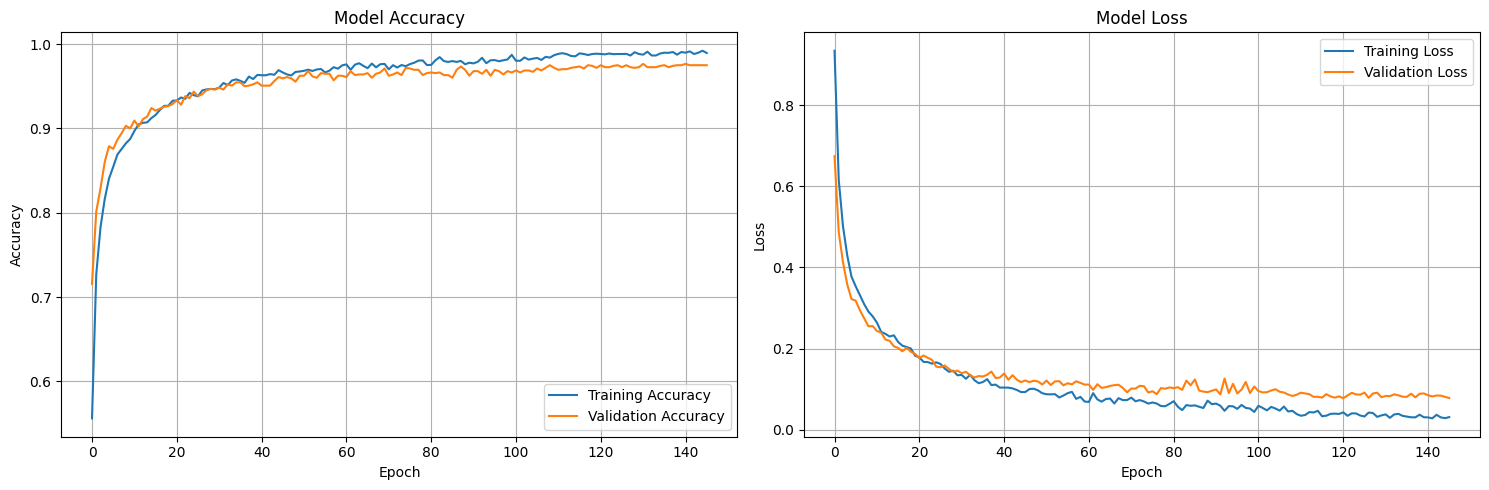

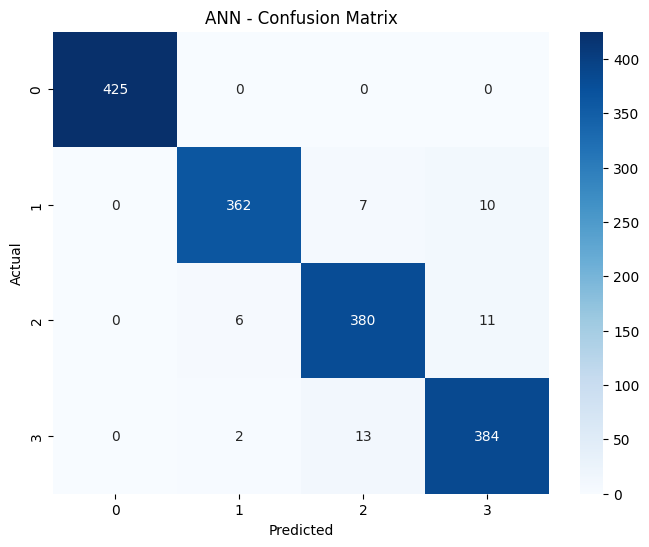

In [12]:
# Plot final training history
plot_training_history(history_final)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('ANN - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step


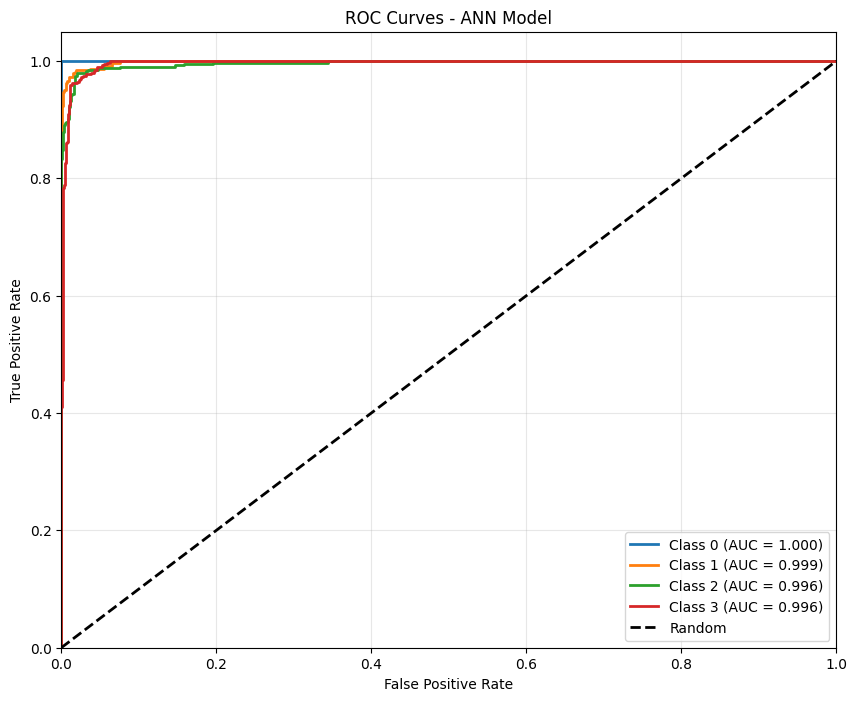

AUC Scores by Class:
  Class 0: 1.0000
  Class 1: 0.9986
  Class 2: 0.9961
  Class 3: 0.9965


In [14]:
# 1. Get predictions from ANN
y_pred_proba = final_ann.predict(X_test)

# 2. Check number of classes
n_classes = len(np.unique(y_test))

# 3. Binarize the labels (convert to one-hot encoding)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# 4. Calculate ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')

# 5. Add random classifier line and format
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - ANN Model')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# 6. Print AUC for each class
print("AUC Scores by Class:")
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"  Class {i}: {roc_auc:.4f}")

In [15]:
# Save the classification report
report_dict = classification_report(y_test, y_pred_final, output_dict=True)
df = pd.DataFrame(report_dict).transpose()
df.to_csv("performance_metrics/classification_reports/ann_report.csv") 

In [16]:
# Save the trained model
final_ann.save('trained_models/ann_model.h5')
print("ANN model saved")

ANN model saved
